Problem 1

1. Leverage less than 1 means your are using only part of your capital. The rest stays uninvested. So basically if you have 100 rupees and you just spend 50 rupees for investment - it means leverage is less than 1.
Yes, it normally makes financial sense. It reduces risk - it might lowers potential return but in volatile and uncertain market condition it might turns out to be good approach
In a backtesting engine, leverage < 1 is especially helpful for testing dynamic position sizing — adjusting how much you invest based on factors like volatility or confidence in a prediction.
2. In static stop trailing loss a fixed bar is set for trade to get exited if it moves against you.
In volatile market , High chance of getting hit due to random price swings, even if the overall trend is favorable.
In Trending Market it may cause early exit if the price dips briefly before trending in your favor
and in trailing stop loss bar moves with trade in your favor and but stay fixed when trade moves against you.
In Trending Market Works well. It allows the position to stay open as long as the trend continues, capturing more profits.
In volatile market , it might get affected by sharp dips resulting in locking small gain due to early exist.
3. A trailing take profit moves upward with price gains, aiming to lock in profits as the market trends upward — much like a trailing stop, but specifically for booking profits instead of cutting losses.
Its behavior can often be captured by a trailing stop loss placed at a profit zone. When the stop moves up with the price and gets hit, it effectively acts as a trailing take profit.
4. trade can remain open even after the price falls below the stop-loss level in several scenarios, primarily due to the nature of market orders, stop-limit orders, and market volatility.
-1. Market Orders and Slippage:
When using a stop-loss order that converts into a market order, the execution price may be worse than the stop-loss level due to market fluctuations. This is known as slippage.
In volatile markets or thinly traded securities, the price might jump below the stop-loss level without touching it, leading to the order not being filled and the trade remaining open.
-2. Stop-Limit Orders and Lack of Liquidity:
Stop-limit orders convert into limit orders after the trigger is reached. If the price drops below the limit price, the order may not be filled if there are no buyers willing to purchase at that price, especially in thinly traded markets.
The order will remain open until the price rises back to the limit level or until it's cancelled.
-3. Trailing Stop-Losses:
Trailing stop-loss orders adjust as the price moves, but they can become locked if the price starts to drop after a period of rising, potentially resulting in a trade remaining open.
-4. Market Volatility and Gaps:
If a stock price suddenly gaps below (or above) the stop price, the order would trigger, but the execution price might be significantly worse than the stop-loss level due to the sudden price movement.



Problem 2





Install and Import Required Libraries

In [ ]:


!pip install yfinance mplfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf



Download 5 Years of OHLCV Data for an NSE Stock

We are taking Reliance

In [ ]:


# Download 5 years of data for Reliance
data = yf.download('RELIANCE.NS', period='5y', interval='1d')

# Flatten multi-level columns if any
data.columns.name = None  # remove 'Ticker' label
data.reset_index(inplace=True)
data.columns = [col if not isinstance(col, tuple) else col[0] for col in data.columns]

[*********************100%***********************]  1 of 1 completed


Defining Pattern Identification Functions

In [ ]:
def is_doji(open_, high, low, close):
    body = abs(close - open_)
    range_ = high - low
    return body < 0.1 * range_

def is_hammer(open_, high, low, close):
    body = abs(close - open_)
    lower_wick = min(open_, close) - low
    upper_wick = high - max(open_, close)
    return (body <= 0.1 * (high - low)) and (lower_wick >= 2 * body) and (upper_wick <= 0.1 * (high - low))

def is_bullish_engulfing(prev_open, prev_close, curr_open, curr_close):
    return (prev_close < prev_open) and (curr_close > curr_open) and (curr_open < prev_close) and (curr_close > prev_open)



Identifying Pattern Occurrences

In [ ]:
data['Doji'] = data.apply(lambda row: is_doji(row['Open'], row['High'], row['Low'], row['Close']), axis=1)
data['Hammer'] = data.apply(lambda row: is_hammer(row['Open'], row['High'], row['Low'], row['Close']), axis=1)

# For Engulfing (requires previous row)
engulfing_flags = [False]
for i in range(1, len(data)):
    prev = data.iloc[i-1]
    curr = data.iloc[i]
    engulfing_flags.append(is_bullish_engulfing(prev['Open'], prev['Close'], curr['Open'], curr['Close']))
data['Engulfing'] = engulfing_flags



In [ ]:
# Ensure 'Date' is datetime and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


In [ ]:
add_plot = []

# Mark Doji candles with blue circles
doji_markers = mpf.make_addplot(data['Close'][data['Doji']], type='scatter', markersize=100, marker='o', color='blue')

# Mark Hammer candles with green upward triangles
hammer_markers = mpf.make_addplot(data['Close'][data['Hammer']], type='scatter', markersize=100, marker='^', color='green')

# Mark Bullish Engulfing with orange stars
engulfing_markers = mpf.make_addplot(data['Close'][data['Engulfing']], type='scatter', markersize=150, marker='*', color='orange')

add_plot += [doji_markers, hammer_markers, engulfing_markers]


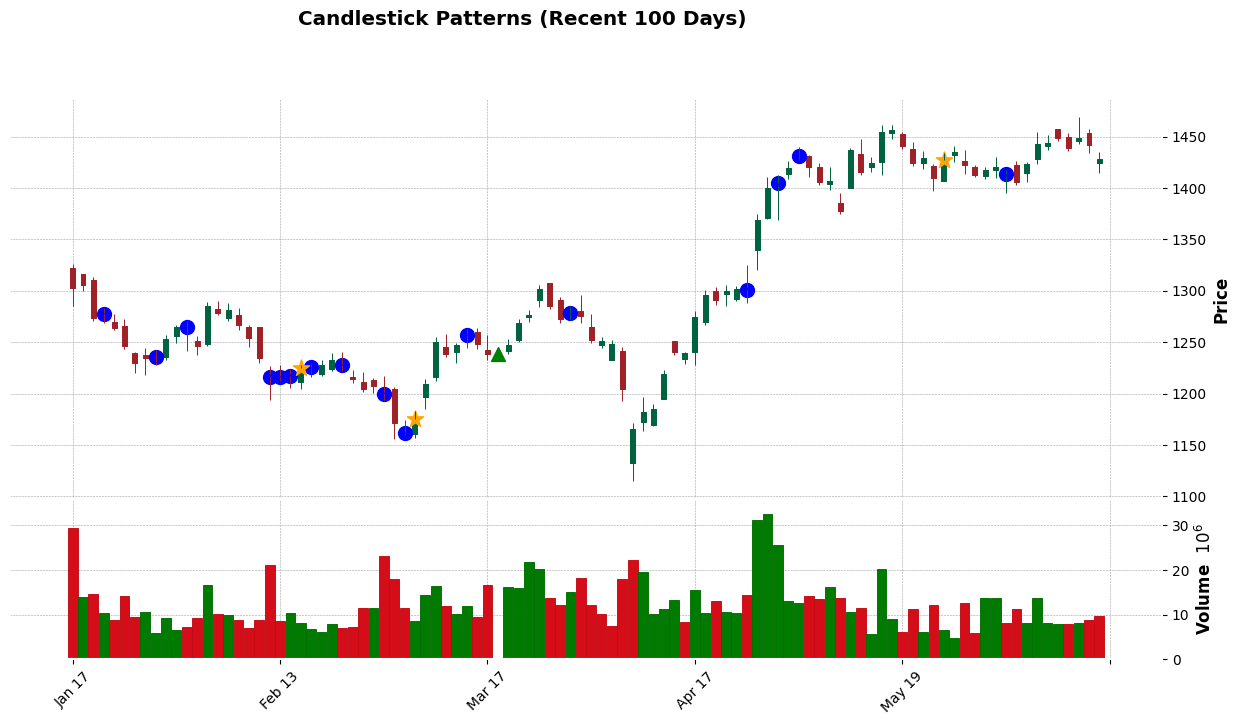

In [ ]:
# Example: last 100 days
data_recent = data.tail(100)

mpf.plot(data_recent,
         type='candle',
         style='charles',
         volume=True,
         addplot=[  # use sliced marker plots too
            mpf.make_addplot(data_recent['Close'].where(data_recent['Doji']), type='scatter', markersize=100, marker='o', color='blue'),
            mpf.make_addplot(data_recent['Close'].where(data_recent['Hammer']), type='scatter', markersize=100, marker='^', color='green'),
            mpf.make_addplot(data_recent['Close'].where(data_recent['Engulfing']), type='scatter', markersize=150, marker='*', color='orange'),
         ],
         title='Candlestick Patterns (Recent 100 Days)',
         figsize=(16, 8))



Win-Rate Calculation Function

In [ ]:
def compute_win_rate(df, pattern_col, n):
    indices = df[df[pattern_col]].index
    wins = 0
    for idx in indices:
        if idx + n < len(df):
            ret = df.loc[idx + n, 'Close'] - df.loc[idx, 'Close']
            if ret > 0:
                wins += 1
    total = len(indices)
    return 100 * wins / total if total > 0 else 0


Baseline Win-Rate

In [ ]:

def baseline_win_rate(df, n, M):
    random_indices = np.random.choice(len(df) - n, M, replace=False)
    wins = sum(df.loc[i + n, 'Close'] > df.loc[i, 'Close'] for i in random_indices)
    return 100 * wins / M


Running  Win-Rate Experiments

In [ ]:
# Initialize empty list for final results
final_results = []

# Calculate pattern win-rates
for pattern in ['Doji', 'Hammer', 'Engulfing']:
    row = {'Pattern': pattern}
    for n in [3, 5]:
        row[f'n={n}'] = compute_win_rate(data, pattern, n)
    final_results.append(row)

# Calculate baseline win-rates
for n in [3, 5]:
    M = int(data[['Doji', 'Hammer', 'Engulfing']].sum().mean())
    baseline_wr = baseline_win_rate(data, n, M)
    for r in final_results:
        r.setdefault(f'Baseline_n={n}', baseline_wr)  # Optional: Store baseline per row
# OR simpler: separate baseline rows
baseline_results = [
    {'Pattern': 'Baseline', f'n=3': baseline_win_rate(data, 3, M), f'n=5': baseline_win_rate(data, 5, M)}
]

# Combine baseline + pattern results
df_results = pd.DataFrame(baseline_results + final_results)



Plotting  Bar Chart

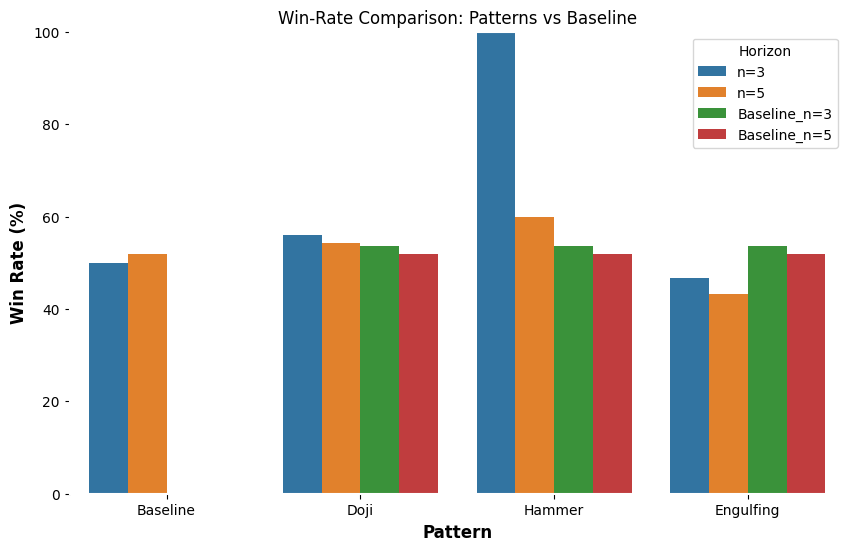

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Reshape for seaborn
df_melted = df_results.melt(id_vars='Pattern', var_name='Horizon', value_name='WinRate')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Pattern', y='WinRate', hue='Horizon')
plt.title('Win-Rate Comparison: Patterns vs Baseline')
plt.ylabel('Win Rate (%)')
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()



**1. Pattern Significance:**
If any candlestick pattern consistently shows a higher win-rate than the baseline across both horizons, it may indicate a real edge. However, statistically significant conclusions require many samples and confidence intervals.

**2. Effect of Changing n:**
As `n` increases from 3 to 5, short-term noise reduces, but responsiveness drops. Win-rates may smooth out or change due to different market behaviors in short vs medium-term.

**3. Consistent Pattern:**
If a pattern (say Hammer) has relatively stable win-rates for both n=3 and n=5, it indicates robust behavior. This may be because its definition captures strong reversal signals, less influenced by time horizon shifts.


Problem 3
1. Chart interpretation

Main Technical Indicators Identified:
Heiken Ashi Candles: Used to smooth out price action and identify trends clearly.

Supertrend (10,3): A trend-following indicator. Green signals an uptrend, red indicates a downtrend.

Money Flow Index (MFI 14): Measures buying and selling pressure using price and volume.

Markings & Zones:

Red/Green Arrows: Signal potential entry points

Green arrows coincide with buy signals – e.g., when price closes above Supertrend and MFI shows increasing buying pressure.

Red arrows coincide with sell signals – e.g., price falls below Supertrend and MFI shows increasing selling pressure.

Trend Zones:

Uptrend Zone: Supertrend is green, Heiken Ashi candles are bullish (usually without lower wicks).

Downtrend Zone: Supertrend is red, Heiken Ashi candles are bearish (usually without upper wicks).

Sideways Zone: Narrow range with price hovering near Supertrend. MFI lacks strong directional movement.

MFI:
When MFI crosses above 50 from below, buying pressure is increasing (highlighted in green ovals).

When MFI crosses below 50 from above, selling pressure is increasing (highlighted in red ovals).

Overbought (~80) and Oversold (~20) thresholds aren't used strictly; instead, trend in MFI itself is emphasized.

2. Entry and Exist rules
Entry Rules
A. Long (Buy) Entry:

Enter a long position when all the following conditions are met:


Supertrend turns green (bullish signal).

Heiken Ashi candles are bullish (typically green with no lower wick).

MFI shows increasing buying pressure, ideally rising from below 50 toward or above it.

Bonus confirmation: MFI crosses above 50, confirming accumulation.

Timing: Entry occurs on the next candle’s close after all conditions are satisfied.

B. Short (Sell) Entry:

Enter a short position when all the following conditions are met:

Supertrend turns red (bearish signal).

Heiken Ashi candles are bearish (typically red with no upper wick).

MFI shows increasing selling pressure, ideally dropping from above 50.

Bonus confirmation: MFI crosses below 50.

Entry on next candle’s close after confirmation.

Exit Rules

Exit Long Position:

Supertrend flips to red, or

MFI starts declining from high levels (e.g., drops from above 60 to below 50), or

A clear bearish Heiken Ashi reversal candle (long upper wick + red body).

Exit Short Position:

Supertrend flips to green, or

MFI starts rising from low levels (e.g., rises from below 40 toward 50), or

A clear bullish Heiken Ashi reversal candle (long lower wick + green body).

3. Strategy Implementation and Backtest



Downloading historical data

In [ ]:
import yfinance as yf
import pandas as pd

def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)
    data.columns.name = None
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns]
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True)
    data['datetime'] = pd.to_datetime(data['datetime'])
    return data

# Download CAMS.NS data
stock_symbol = 'CAMS.NS'
data = download_flat_yf(stock_symbol, start='2024-01-01', end='2025-05-04', interval='1d')


Heiken Ashi Transformation (for Supertrend)

In [ ]:
def heiken_ashi(df):
    ha_df = df.copy()
    ha_df['ha_close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

    ha_open = [(df['open'][0] + df['close'][0]) / 2]
    for i in range(1, len(df)):
        ha_open.append((ha_open[i - 1] + ha_df['ha_close'][i - 1]) / 2)
    ha_df['ha_open'] = ha_open

    ha_df['ha_high'] = ha_df[['ha_open', 'ha_close', 'high']].max(axis=1)
    ha_df['ha_low'] = ha_df[['ha_open', 'ha_close', 'low']].min(axis=1)

    return ha_df

data_ha = heiken_ashi(data)


Adding Supertrend Indicator (using Heiken Ashi)

In [ ]:
import numpy as np

def calculate_supertrend(df, period=10, multiplier=3):
    atr = df['high'].rolling(window=period).max() - df['low'].rolling(window=period).min()
    atr = atr.rolling(window=period).mean()

    hl2 = (df['ha_high'] + df['ha_low']) / 2
    upperband = hl2 + multiplier * atr
    lowerband = hl2 - multiplier * atr

    supertrend = [True]
    for i in range(1, len(df)):
        if df['close'][i] > upperband[i - 1]:
            supertrend.append(True)
        elif df['close'][i] < lowerband[i - 1]:
            supertrend.append(False)
        else:
            supertrend.append(supertrend[i - 1])

    df['supertrend'] = supertrend
    df['supertrend_direction'] = ['green' if x else 'red' for x in supertrend]
    return df

data_ha = calculate_supertrend(data_ha)


 Adding  Money Flow Index (MFI)


In [ ]:
def calculate_mfi(df, period=14):
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    money_flow = typical_price * df['volume']

    positive_flow = []
    negative_flow = []

    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i - 1]:
            positive_flow.append(money_flow[i])
            negative_flow.append(0)
        else:
            negative_flow.append(money_flow[i])
            positive_flow.append(0)

    mfi = 100 * (pd.Series(positive_flow).rolling(window=period).sum() /
                 (pd.Series(positive_flow).rolling(window=period).sum() +
                  pd.Series(negative_flow).rolling(window=period).sum()))

    mfi = mfi.reindex(df.index, method='bfill')
    df['mfi'] = mfi
    return df

data_ha = calculate_mfi(data_ha)


Generating Trading Signals

In [ ]:
def generate_signals(df):
    df['long_entry'] = (
        (df['supertrend_direction'] == 'green') &
        (df['mfi'] > 50)
    )

    df['long_exit'] = (
        (df['supertrend_direction'] == 'red') |
        (df['mfi'] < 50)
    )

    df['position'] = 0
    position = 0
    for i in range(len(df)):
        if df['long_entry'][i]:
            position = 1
        elif df['long_exit'][i]:
            position = 0
        df.at[i, 'position'] = position

    return df

data_ha = generate_signals(data_ha)


Backtest the Strategy

In [ ]:
def backtest_strategy(df):
    df['returns'] = df['close'].pct_change()
    df['strategy_returns'] = df['position'].shift(1) * df['returns']
    cumulative_returns = (1 + df[['returns', 'strategy_returns']]).cumprod()
    return cumulative_returns

cumulative_returns = backtest_strategy(data_ha)


Visualize Backtest

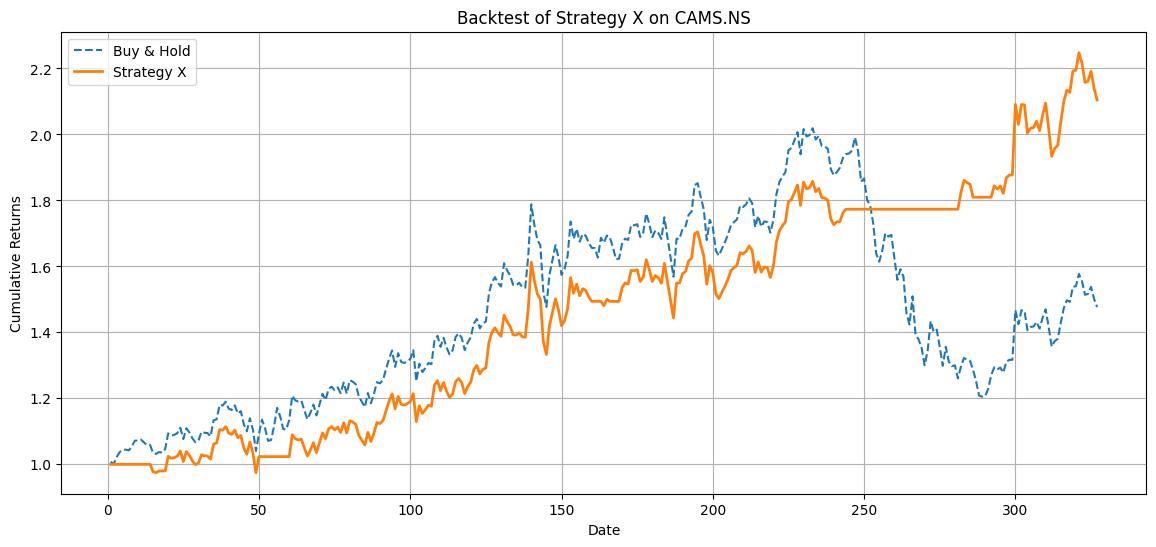

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(cumulative_returns['returns'], label='Buy & Hold', linestyle='--')
plt.plot(cumulative_returns['strategy_returns'], label='Strategy X', linewidth=2)
plt.title('Backtest of Strategy X on CAMS.NS')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


4. Incorporating a Complementary Indicator (Strategy Y)
Proposed Complementary Indicator: Average True Range (ATR)
Why ATR?
The current Strategy X combines trend direction (via Supertrend on Heiken Ashi) and volume-pressure dynamics (via MFI). However, both of these can misfire during volatile or choppy markets. To address this:

ATR adds a volatility filter, helping to distinguish between strong directional moves and random noise.

ATR ensures that trades are taken only when price momentum is supported by sufficient volatility—reducing false signals.

ndicator Explanation
ATR is a measure of market volatility.

We’ll use it to filter trades:

Only allow long entries when ATR is above its moving average (i.e., current volatility is expanding).

This ensures that entries happen in momentum-backed environments.

Define Strategy Y
Strategy Y Entry Condition:

Supertrend indicates uptrend

MFI > 50 (buying pressure)

ATR > ATR SMA → confirms expanding volatility

Exit Condition:

Supertrend turns red (trend reversal)

OR MFI < 50

OR ATR drops below its SMA → weakening volatility

 Code Implementation for Strategy Y

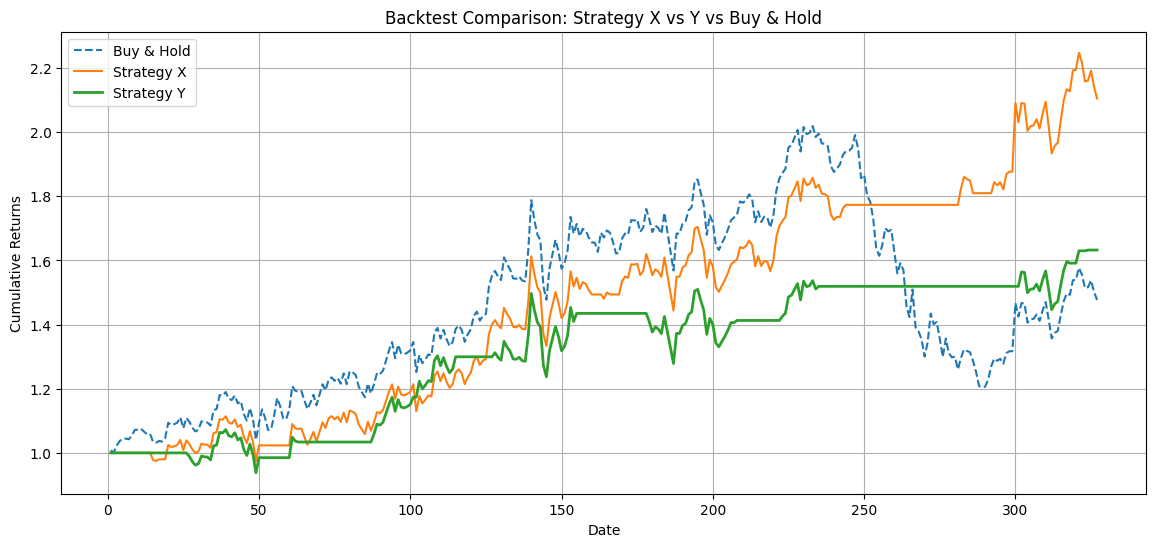

In [ ]:
def calculate_atr(df, period=14):
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())

    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()

    df['atr'] = atr
    df['atr_sma'] = atr.rolling(window=period).mean()
    return df
#modifying singal generation with ATR filter
data_ha = calculate_atr(data_ha)
def generate_strategy_y_signals(df):
    df['long_entry_y'] = (
        (df['supertrend_direction'] == 'green') &
        (df['mfi'] > 50) &
        (df['atr'] > df['atr_sma'])
    )

    df['long_exit_y'] = (
        (df['supertrend_direction'] == 'red') |
        (df['mfi'] < 50) |
        (df['atr'] < df['atr_sma'])
    )

    df['position_y'] = 0
    position = 0
    for i in range(len(df)):
        if df['long_entry_y'][i]:
            position = 1
        elif df['long_exit_y'][i]:
            position = 0
        df.at[i, 'position_y'] = position

    return df
#backtest strategy Y
data_ha = generate_strategy_y_signals(data_ha)
def backtest_strategy_y(df):
    df['strategy_y_returns'] = df['position_y'].shift(1) * df['returns']
    cumulative_returns_y = (1 + df[['returns', 'strategy_returns', 'strategy_y_returns']]).cumprod()
    return cumulative_returns_y

#visualization of Strategy Y vs X vs Buy & Hold
cumulative_returns_y = backtest_strategy_y(data_ha)
plt.figure(figsize=(14, 6))
plt.plot(cumulative_returns_y['returns'], label='Buy & Hold', linestyle='--')
plt.plot(cumulative_returns_y['strategy_returns'], label='Strategy X')
plt.plot(cumulative_returns_y['strategy_y_returns'], label='Strategy Y', linewidth=2)
plt.title('Backtest Comparison: Strategy X vs Y vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


5. Strategy Enhancements

Identifying Market Regimes Where Strategy May Underperform
Based on Strategy X and Y (Supertrend + MFI + ATR), certain market regimes may pose challenges:

Sideways/Choppy Markets:

Supertrend keeps flipping signals frequently.

MFI oscillates near 50 → no strong buying/selling pressure.

ATR drops → low volatility.

Effect: Multiple false entries and exits.

Low-Volume Phases:

MFI becomes less reliable (volume-based oscillator).

Supertrend lags in capturing reversal.

ATR remains low → strategy avoids entries, but may miss breakout potential.

Sudden Gaps/News-Driven Moves:

Price gaps skip trigger conditions.

Strategy reacts late, entering at unfavorable prices.

Enhancement Proposals
1. Time-Frame Adjustment
Use multi-timeframe confirmation:

E.g., Check Supertrend on 1D and 4H charts. Enter only if both agree.

Smoothens out noisy 1D signals.

2. Volatility-Based Filters (Already Added with ATR)
Retain ATR but also add:

ATR breakout detection: Only trade when ATR crosses recent max → likely momentum shift.

3. Volume Surge Filter
Add a condition: volume today > 1.5× 20-day average.

Confirms strength behind the move (validates MFI signals).

4. Trend Confirmation Using Moving Averages
Require price to be above 50 EMA for long, below for short.

Filters out trades against dominant trend.

Refined Strategy Y+ (with Enhancements)
Entry Conditions:

Supertrend = green

MFI > 50

ATR > ATR SMA

Volume > 1.5× 20-day avg

Price > 50 EMA

Exit Conditions:

Any of the above fails.